In [2]:
from imports import *

In [3]:
class polynomialCp:
    def __init__(self, component):
        
        conn = sqlite3.connect('database.db')
        cursor = conn.cursor()

        cursor.execute('''
            SELECT  a1_cold, a2_cold, a3_cold, a4_cold, a5_cold,
                    a1_hot, a2_hot, a3_hot, a4_hot, a5_hot,
                    minColdTemp, maxColdTemp, minHotTemp, maxHotTemp,
                    MolWeight, Hf0
            FROM termoquimica
            WHERE Component = ?
        ''', (component,))

        data = cursor.fetchone()
        conn.close()

        coefs = [(data[i],  data[i+5]) for i in range(5)]
        temps = [(data[i],  data[i+2]) for i in range(10,12)]
        props = data[14:]

        self.a1_cold, self.a1_hot =  coefs[0]
        self.a2_cold, self.a2_hot =  coefs[1]
        self.a3_cold, self.a3_hot =  coefs[2]
        self.a4_cold, self.a4_hot =  coefs[3]
        self.a5_cold, self.a5_hot =  coefs[4]

        self.minColdTemp, self.maxColdTemp = temps[0]
        self.minHotTemp, self.maxHotTemp = temps[1]

        self.MolWeight, self.Hf0 = props

    def cp(self,T):
        if self.minColdTemp <= T < self.maxColdTemp:
            value = self.R*(
                self.a1_cold +
                self.a2_cold * T +
                self.a3_cold * T**2 +
                self.a4_cold * T**3 +
                self.a5_cold * T**4
            )
        elif self.minHotTemp <= T < self.maxHotTemp:
            value = self.R*(
                self.a1_hot +
                self.a2_hot * T +
                self.a3_hot * T**2 +
                self.a4_hot * T**3 +
                self.a5_hot * T**4
            )
        else:
            value = 0
        return value
        


In [10]:
reac = [(5,'H2'),(1,'O2')]
prod = [(2,'H2O'), (3,'H2')]

# Extraer los números


def integration(f,a,b,h):
    return h * ( (f(a) + f(b))/2 + sum([f(a + k*h) for k in range(1, int((b - a)/h))]))

def adiabaticTemp_calc(reac, prod, t0, tGuess, hStep):

    reac_moles = [item[0] for item in reac]
    prod_moles = [item[0] for item in prod]

    reac_comps = [polynomialCp(item[1]) for item in reac]
    prod_comps = [polynomialCp(item[1]) for item in prod]

    hf0_reac = sum([n * r.Hf0 for n,r in zip(reac_moles,reac_comps)])
    hf0_prod = sum([n * p.Hf0 for n,p in zip(prod_moles,prod_comps)])
    
    def heat_balance(t):

        hCp_reac = sum([n * integration(r.cp, 298, t0, hStep) for n,r in zip(reac_moles,reac_comps)])
        hCp_prod = sum([n * integration(p.cp, 298, t,  hStep) for n,p in zip(prod_moles,prod_comps)])

        Q_Disp = hf0_reac + hCp_reac
        Q_Req  = hf0_prod + hCp_prod

        delta = (Q_Disp - Q_Req)
        return delta
    

    def newton_raphson(f, x0, tol=hStep, max_iter=10000, h=hStep):
        """
        Método de Newton-Raphson para encontrar las raíces de una función.

        Args:
        f: función objetivo.
        x0: valor inicial para la raíz.
        tol: tolerancia para la convergencia.
        max_iter: número máximo de iteraciones.
        h: paso pequeño para la derivada numérica.

        Returns:
        La raíz aproximada de la función.
        """
        def fp(f, x, h):
            return (f(x + h) - f(x - h)) / (2 * h)

        x = x0
        for i in range(max_iter):
            fx = f(x)
            dfx = fp(f, x, h)

            if dfx == 0:
                raise ValueError("Derivada nula. El método de Newton-Raphson no puede continuar.")

            x_new = x - fx / dfx

            if abs(x_new - x) < tol:
                return x_new

            x = x_new

        raise ValueError("El método de Newton-Raphson no convergió en el número máximo de iteraciones.")

    prodMol         = sum([n for n in prod_moles])
    tSol            = newton_raphson(heat_balance, tGuess)
    molWeight_prod  = (sum([n * r.MolWeight for n,r in zip(prod_moles,prod_comps)]) / prodMol)*1e-3
    cp_Mass         =  (sum([n * r.cp(tSol) for n,r in zip(prod_moles,prod_comps)]) / prodMol) / molWeight_prod
    R_prod          = 8.31446261815324/molWeight_prod
    cv_Mass         = cp_Mass - R_prod
    gamma           = cp_Mass/(cp_Mass - R_prod)

    return tSol, cp_Mass, molWeight_prod, cp_Mass, cv_Mass, R_prod, gamma

adiabaticTemp_calc(reac, prod, 300, 1000, 1)

(2833.177846183625,
 5283.948034423712,
 0.00841564,
 5283.948034423712,
 4295.970576006617,
 987.9774584170948,
 1.2299777060706696)

In [11]:
from imports import *

def newtonRaph(f, x0, tol, max_iter, h):
    """
    Método de Newton-Raphson para encontrar las raíces de una función.
    Args:
    f: función objetivo.
    x0: valor inicial para la raíz.
    tol: tolerancia para la convergencia.
    max_iter: número máximo de iteraciones.
    h: paso pequeño para la derivada numérica.
    Returns:
    La raíz aproximada de la función.
    """
    def fp(f, x, h):
        return (f(x + h) - f(x - h)) / (2 * h)

    x = x0
    for i in range(max_iter):
        fx = f(x)
        dfx = fp(f, x, h)

        if dfx == 0:
            return print("Error", "Derivada nula. El método de Newton-Raphson no puede continuar.")

        x_new = x - fx / dfx

        if abs(x_new - x) < tol:
            return x_new

        x = x_new

    return print("Error", "El método de Newton-Raphson no convergió en el número máximo de iteraciones.")

def integration(f,a,b,h):
    return h * ( (f(a) + f(b))/2 + sum([f(a + k*h) for k in range(1, int((b - a)/h))]))

def discreteIntegration(fs, xs):
    return sum([(xs[i+1] - xs[i]) * (fs[i+1] + fs[i]) / 2 for i in range(len(fs)-1)])

class TubularGrain:
    def __init__(self, inputs):
        # Lista de atributos que quieres asignar
        attributes = [
            "rIn_0b", "rOut", "rThrt", "lComb", 
            "rho_b", "a", "n", "gamma", "R", "T1", "P1_min","P1_max",
            "delta_r", "P0"
        ]
        
        for attr, value in zip(attributes, inputs):
            setattr(self, attr, value)
        
        self.P, self.G, self.M, self.t = self.combTime()
        self.meanPressurem, self.meanMassFlow = self.mean_values()
        self.combustion_time = float(self.t[-1])
        self.combustion_mass = float(self.M[0])


    def combTime(self):

        C = (((np.pi * self.rThrt**2 * self.gamma) / (self.rho_b * self.a * 1e-2)))
        R = np.sqrt( (2/(self.gamma + 1))**((self.gamma - 1)/(self.gamma + 1)) / (self.gamma * self.R * self.T1) )

        rt = np.arange(self.rIn_0b, self.rOut + self.delta_r, self.delta_r)
        size = len(rt)

        P  = np.zeros(size)
        G  = np.zeros(size)
        dt = np.zeros(size)
        m  = np.zeros(size)


        def Ab(ti):
            return 2 * np.pi * self.lComb * rt[ti]

        def M(ti):
            return np.pi * self.rho_b * self.lComb * (self.rOut**2 - rt[ti]**2)

        P[0] = self.P0
        G[0] = Ab(0) * self.rho_b * self.a * P[0]**self.n * 1e-2
        dt[0] = (M(0) - M(1)) / G[0]
        m[0] = M(0)

        def iterCalc(ti):
            P_i = ((C / Ab(ti)) * R)**(1/(self.n - 1))
            G_i = Ab(ti) * self.rho_b * self.a * P_i**self.n * 1e-2
            m_i = M(ti)
            dt_i = (M(ti - 1) - M(ti)) / G_i
            return P_i, G_i, m_i ,dt_i

        for i in range(1, size-1):
            P[i], G[i], m[i], dt[i] = iterCalc(i)

            if P[i] > self.P1_max or P[i] < self.P1_min:
                return print("Error PMax")

        P[-1], G[-1], m[-1] = self.P0, 0, 0

        return P, G, m, np.cumsum(dt)
    
    def mean_values(self):
        interval = self.t[-1] - self.t[0]
        mean_pressure = float(discreteIntegration(self.P, self.t) / interval)
        mean_massflow = float(discreteIntegration(self.G, self.t) / interval)
        return mean_pressure, mean_massflow
    
    def pressureGraph(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.t, self.P, label='Pressure')
        plt.xlabel('Time (s)')
        plt.ylabel('Pressure (Pa)')
        plt.title('Pressure vs Time')
        plt.legend()
        plt.grid(True)
        plt.show()

    def massFlowGraph(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.t, self.G, label='Pressure')
        plt.xlabel('Time (s)')
        plt.ylabel('Pressure (Pa)')
        plt.title('Pressure vs Time')
        plt.legend()
        plt.grid(True)
        plt.show()

    def massTimeGraph(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.t, self.M, label='Pressure')
        plt.xlabel('Time (s)')
        plt.ylabel('Pressure (Pa)')
        plt.title('Pressure vs Time')
        plt.legend()
        plt.grid(True)
        plt.show()

    


  
            
                
            
        



In [13]:
[None]*3

[None, None, None]

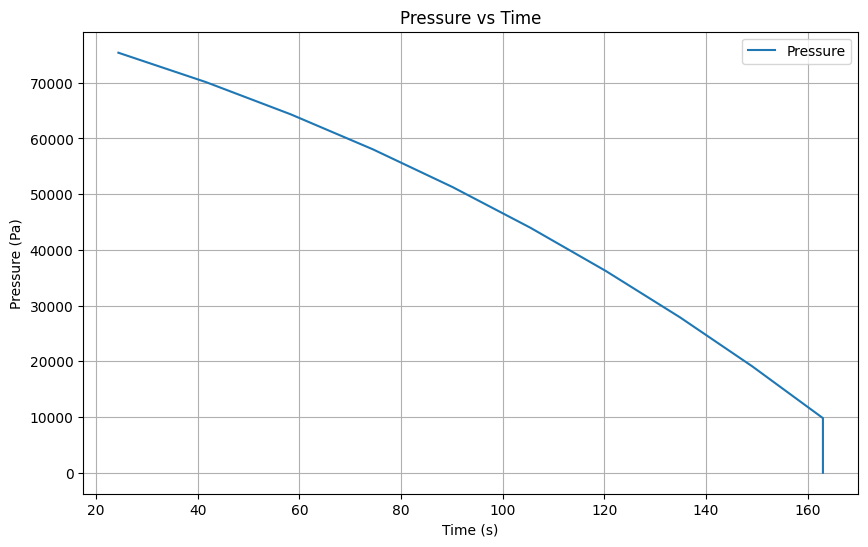

In [12]:
inputs = [1.0, 2.0, 0.5, 8.0, 1000, 0.01356, 0.3, 1.1500486035685251, 223.5507823901452, 1852.148185422294, 0, 12000000, 0.1, 101325.0]
# Crear una instancia de TubularGrain
grain = TubularGrain(inputs)

# Llamar al método engineGraph para mostrar el dibujo
grain.massTimeGraph()

In [55]:
import customtkinter as ctk
from PIL import Image

# Crear la ventana principal
root = ctk.CTk()
root.geometry("400x300")
root.title("CustomTkinter OptionMenu with Images")

# Función para manejar la selección del menú
def option_menu_callback(choice):
    print(f"Selected option: {choice}")
    selected_label.configure(text=f"Selected: {choice}")

# Cargar imágenes (asegúrate de que las imágenes estén en la misma carpeta o proporciona la ruta correcta)
img1 = ctk.CTkImage(light_image=Image.open("image1.png"), size=(50, 50))
img2 = ctk.CTkImage(light_image=Image.open("image2.png"), size=(50, 50))
img3 = ctk.CTkImage(light_image=Image.open("image3.png"), size=(50, 50))

# Crear una lista de opciones con imágenes
options = [("Option 1", img1), ("Option 2", img2), ("Option 3", img3)]

# Variable para almacenar la opción seleccionada
selected_option = ctk.StringVar(value="Select an Option")

# Frame para contener el menú personalizado
menu_frame = ctk.CTkFrame(root)
menu_frame.pack(pady=20)

def show_menu():
    for widget in menu_frame.winfo_children():
        widget.destroy()
    for option, image in options:
        button = ctk.CTkButton(menu_frame, text=option, image=image, compound="left",
                               command=lambda opt=option: [option_menu_callback(opt), hide_menu()])
        button.pack(fill='x')

def hide_menu():
    for widget in menu_frame.winfo_children():
        widget.destroy()

# Botón para mostrar el menú
show_menu_button = ctk.CTkButton(root, textvariable=selected_option, command=show_menu)
show_menu_button.pack(pady=20)

# Label para mostrar la opción seleccionada
selected_label = ctk.CTkLabel(root, text="Selected: None")
selected_label.pack(pady=20)

# Ejecutar el bucle principal de la ventana
root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\tkinter\__init__.py", line 1968, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\site-packages\customtkinter\windows\widgets\ctk_button.py", line 554, in _clicked
    self._command()
  File "C:\Users\marco\AppData\Local\Temp\ipykernel_14664\2966626305.py", line 33, in show_menu
    button = ctk.CTkButton(menu_frame, text=option, image=image, compound="left",
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\site-packages\customtkinter\windows\widgets\ctk_button.py", line 106, in __init__
    self._draw()
  File "c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\site-packages\customtkinter\windows\widgets\ctk_button.py", line 264, in _draw
    self._update_image()  

KeyboardInterrupt: 

In [2]:
import customtkinter as ctk
import tkinter as tk

class OptionMenuTabView(ctk.CTk):
    def __init__(self):
        super().__init__()
        self.title("OptionMenu as TabView")
        self.geometry("600x400")

        self.option_menu = ctk.CTkOptionMenu(self, values=["Tab 1", "Tab 2", "Tab 3"], command=self.change_tab)
        self.option_menu.grid(row=0, column=0, padx=20, pady=20)

        self.tab_frames = {
            "Tab 1": self.create_tab1(),
            "Tab 2": self.create_tab2(),
            "Tab 3": self.create_tab3()
        }

        self.current_frame = None
        self.change_tab("Tab 1")

    def change_tab(self, selected_tab):
        if self.current_frame:
            self.current_frame.grid_forget()
        
        self.current_frame = self.tab_frames[selected_tab]
        self.current_frame.grid(row=1, column=0, padx=20, pady=20, sticky="nsew")

    def create_tab1(self):
        frame = ctk.CTkFrame(self)
        label = ctk.CTkLabel(frame, text="This is Tab 1")
        label.grid(row=0, column=0, padx=10, pady=10)
        self.entry1 = ctk.CTkEntry(frame)
        self.entry1.grid(row=1, column=0, padx=10, pady=10)
        return frame

    def create_tab2(self):
        frame = ctk.CTkFrame(self)
        label = ctk.CTkLabel(frame, text="This is Tab 2")
        label.grid(row=0, column=0, padx=10, pady=10)
        self.entry2 = ctk.CTkEntry(frame)
        self.entry2.grid(row=1, column=0, padx=10, pady=10)
        return frame

    def create_tab3(self):
        frame = ctk.CTkFrame(self)
        label = ctk.CTkLabel(frame, text="This is Tab 3")
        label.grid(row=0, column=0, padx=10, pady=10)
        self.entry3 = ctk.CTkEntry(frame)
        self.entry3.grid(row=1, column=0, padx=10, pady=10)
        return frame

if __name__ == "__main__":
    app = OptionMenuTabView()
    app.mainloop()